In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/MyDrive/Assignment/Project_data.zip" > /dev/null

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
project_folder='Project_data'

In [5]:
#importing the necessary libraries

import numpy as np
import os
import imageio
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as k
import tensorflow as tf
tf.random.set_seed(30)

In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# importing some other libraries which will be needed for model building

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [9]:
# function to plot the training/validation accuracies/losses.

def plot(history):
  fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(15,4))
  axes[0].plot(history.history['loss'])
  axes[0].plot(history.history['val_loss'])
  axes[0].grid()
  axes[0].legand(['loss','val_loss'])
  axes[1].plot(history.history['categorical_accuracy'])
  axes[1].plot(history.history['val_categorical_accuracy'])
  axes[1].grid()
  axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])


In [10]:
class ModelBuilder(metaclass=abc.ABCMeta):
    # Method to initialize paths where project data resides
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())  # Shuffle training data
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())  # Shuffle validation data
        self.train_path = project_folder + '/' + 'train'  # Path to training data
        self.val_path = project_folder + '/' + 'val'  # Path to validation data
        self.num_train_sequences = len(self.train_doc)  # Number of training sequences
        self.num_val_sequences = len(self.val_doc)  # Number of validation sequences

    # Method to initialize image properties
    def initialize_image_properties(self, image_height=100, image_width=100):
        self.image_height = image_height  # Height of the image
        self.image_width = image_width  # Width of the image
        self.channels = 3  # Number of image channels (RGB)
        self.num_classes = 5  # Number of classes for classification
        self.total_frames = 30  # Total number of frames in each video

    # Method to initialize hyperparameters: batch size, frames to sample, and number of epochs
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample  # Number of frames to sample from each video
        self.batch_size = batch_size  # Batch size for training
        self.num_epochs = num_epochs  # Number of epochs for training

    # Generator function to yield batches of data
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)  # Indices of frames to sample
        batch_size = self.batch_size  # Batch size for training
        while True:
            t = np.random.permutation(folder_list)  # Shuffle folder list
            num_batches = len(t) // batch_size  # Number of batches per epoch

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)  # Get one batch of data
                yield batch_data, batch_labels  # Yield batch data and labels

            remaining_seq = len(t) % batch_size  # Remaining sequences if not divisible by batch size

            if remaining_seq != 0:
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)  # Get remaining sequences
                yield batch_data, batch_labels  # Yield remaining batch data and labels

    # Method to get data for one batch
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size  # Length of the sequence (batch size or remaining sequences)

        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))  # Initialize batch data array
        batch_labels = np.zeros((seq_len, self.num_classes))  # Initialize batch labels array

        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))  # Initialize augmented data array

        for folder in range(seq_len):
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])  # List of images in the folder
            for idx, item in enumerate(img_idx):
                # Reading and resizing the image
                image = imageio.imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))

                # Normalizing the images
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                if augment:
                    # Applying random shifts to the image
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]),
                                             (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    # Cropping the images to target gestures and remove noise
                    cropped = shifted[x0:x1, y0:y1, :]

                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))

                    # Normalizing the augmented images
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # One-hot encoding the labels

        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])  # Concatenating original and augmented data
            batch_labels = np.concatenate([batch_labels, batch_labels])  # Concatenating original and augmented labels

        return batch_data, batch_labels  # Returning batch data and labels

    # Method to train the model
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)  # Training data generator
        val_generator = self.generator(self.val_path, self.val_doc)  # Validation data generator

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'  # Model name with timestamp

        if not os.path.exists(model_name):
            os.mkdir(model_name)  # Create directory for saving the model

        # filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'  # Filepath for saving the model
        # As per the req saving files in .h5 format
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'  # Filepath for saving the model

        # Callbacks for saving the best model and reducing learning rate on plateau
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        # earlystop = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=1)
        # callbacks_list = [checkpoint, LR, earlystop]
        callbacks_list = [checkpoint, LR]  # List of callbacks

        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)  # Calculate steps per epoch
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences / self.batch_size)  # Calculate validation steps
        else:
            validation_steps = (self.num_val_sequences // self.batch_size) + 1

        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)  # Train the model
        return history  # Return training history

    @abc.abstractmethod
    def define_model(self):
        pass  # Abstract method to define the model architecture


In [11]:
class ModelConv3D1(ModelBuilder):

    def define_model(self):
        # Define the 3D convolutional neural network model

        model = Sequential()  # Initialize the model as a sequential model

        # First 3D convolutional layer
        model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))  # ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

        # Second 3D convolutional layer
        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))  # ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

        # Third 3D convolutional layer
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))  # ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

        # Fourth 3D convolutional layer
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))  # ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

        model.add(Flatten())  # Flatten the output from the convolutional layers

        # First dense (fully connected) layer
        model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(Dropout(0.5))  # Dropout for regularization

        # Second dense (fully connected) layer
        model.add(Dense(64, activation='relu'))  # Dense layer with ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(Dropout(0.25))  # Dropout for regularization

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))  # Output layer with softmax activation

        optimiser = optimizers.Adam()  # Using Adam optimizer
        # optimiser = 'sgd'  # Alternative optimizer (commented out)

        # Compile the model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model  # Return the compiled model

In [12]:
conv_3d1 = ModelConv3D1()  # Instantiate the ModelConv3D1 class

conv_3d1.initialize_path(project_folder)  # Initialize paths where project data resides
conv_3d1.initialize_image_properties(image_height=160, image_width=160)  # Initialize image properties with specified height and width
conv_3d1.initialize_hyperparams(frames_to_sample=30, batch_size=10, num_epochs=1)  # Initialize hyperparameters with specified values

conv_3d1_model = conv_3d1.define_model()  # Define the model using the method from ModelConv3D1 class
conv_3d1_model.summary()  # Print the summary of the model architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 160, 160, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4

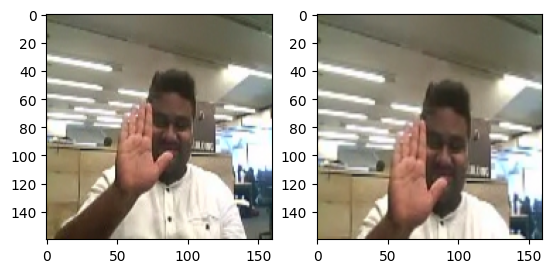

In [13]:
test_generator = ModelConv3D1()  # Instantiate the ModelConv3D1 class for testing the generator

test_generator.initialize_path(project_folder)  # Initialize paths where project data resides
test_generator.initialize_image_properties(image_height=160, image_width=160)  # Initialize image properties with specified height and width
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3, num_epochs=1)  # Initialize hyperparameters with specified values

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)  # Create a generator for validation data with augmentation
batch_data, batch_labels = next(g)  # Generate one batch of data and labels

fig, axes = plt.subplots(nrows=1, ncols=2)  # Create a figure with 2 subplots side by side
axes[0].imshow(batch_data[0, 15, :, :, :])  # Display the 16th frame of the first sample in the batch
axes[1].imshow(batch_data[3, 15, :, :, :])  # Display the 16th frame of the fourth sample in the batch
plt.show()  # Show the plots

In [ ]:
conv_3d1 = ModelConv3D1()  # Instantiate the ModelConv3D1 class

conv_3d1.initialize_path(project_folder)  # Initialize paths where project data resides
conv_3d1.initialize_image_properties(image_height=100, image_width=100)  # Initialize image properties with specified height and width
conv_3d1.initialize_hyperparams(frames_to_sample=20, batch_size=30, num_epochs=2)  # Initialize hyperparameters with specified values

conv_3d1_model = conv_3d1.define_model()  # Define the model using the method from ModelConv3D1 class

print("Total Params:", conv_3d1_model.count_params())  # Print the total number of parameters in the model

conv_3d1.train_model(conv_3d1_model)  # Train the model using the train_model method from the ModelConv3D1 class

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.5867 - categorical_accuracy: 0.4178
Epoch 1: val_loss improved from inf to 2.09892, saving model to model_init_2024-07-0710_41_41.119797/model-00001-1.58665-0.41780-2.09892-0.21000.h5
23/23 [==============================] - 145s 6s/step - loss: 1.5867 - categorical_accuracy: 0.4178 - val_loss: 2.0989 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.1554 - categorical_accuracy: 0.5732
Epoch 2: val_loss did not improve from 2.09892
23/23 [==============================] - 140s 6s/step - loss: 1.1554 - categorical_accuracy: 0.5732 - val_loss: 2.3490 - val_categorical_accuracy: 0.2100 - lr: 0.0010


In [ ]:
conv_3d1 = ModelConv3D1()  # Instantiate the ModelConv3D1 class

conv_3d1.initialize_path(project_folder)  # Initialize paths where project data resides
conv_3d1.initialize_image_properties(image_height=100, image_width=100)  # Initialize image properties with specified height and width
conv_3d1.initialize_hyperparams(frames_to_sample=30, batch_size=20, num_epochs=2)  # Initialize hyperparameters with specified values

conv_3d1_model = conv_3d1.define_model()  # Define the model using the method from ModelConv3D1 class

print("Total Params:", conv_3d1_model.count_params())  # Print the total number of parameters in the model

conv_3d1.train_model(conv_3d1_model)  # Train the model using the train_model method from the ModelConv3D1 class

Total Params: 687813
Epoch 1/2
 6/34 [====>.........................] - ETA: 2:00 - loss: 1.9968 - categorical_accuracy: 0.3667

In [14]:
class ModelConv3D1(ModelBuilder):

    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64, dropout=0.25):
        # Define the 3D convolutional neural network model with customizable parameters

        model = Sequential()  # Initialize the model as a sequential model

        # First 3D convolutional layer
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))  # ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

        # Second 3D convolutional layer
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))  # ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

        # Third 3D convolutional layer
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))  # ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

        # Fourth 3D convolutional layer
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))  # ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Max pooling

        model.add(Flatten())  # Flatten the output from the convolutional layers

        # First dense (fully connected) layer
        model.add(Dense(dense_neurons, activation='relu'))  # Dense layer with ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(Dropout(dropout))  # Dropout for regularization

        # Second dense (fully connected) layer
        model.add(Dense(dense_neurons, activation='relu'))  # Dense layer with ReLU activation
        model.add(BatchNormalization())  # Batch normalization
        model.add(Dropout(dropout))  # Dropout for regularization

        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))  # Output layer with softmax activation

        optimiser = optimizers.Adam()  # Using Adam optimizer

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])  # Compile the model

        return model  # Return the compiled model

In [15]:
conv_3d1 = ModelConv3D1()  # Instantiate the ModelConv3D1 class

conv_3d1.initialize_path(project_folder)  # Initialize paths where project data resides
conv_3d1.initialize_image_properties(image_height=160, image_width=160)  # Initialize image properties with specified height and width
conv_3d1.initialize_hyperparams(frames_to_sample=20, batch_size=40, num_epochs=2)  # Initialize hyperparameters with specified values

conv_3d1_model = conv_3d1.define_model()  # Define the model using the method from ModelConv3D1 class
conv_3d1_model.summary()  # Print the summary of the model architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 20, 160, 160, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)   

In [ ]:
# Print the total number of parameters in the model
print("Total Params:", conv_3d1_model.count_params())

# Train the model using the train_model method from the ModelConv3D1 class
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.6674 - categorical_accuracy: 0.3831
Epoch 1: val_loss improved from inf to 1.60923, saving model to model_init_2024-07-0710_59_39.553319/model-00001-1.66744-0.38311-1.60923-0.22000.h5
17/17 [==============================] - 198s 11s/step - loss: 1.6674 - categorical_accuracy: 0.3831 - val_loss: 1.6092 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
 7/17 [===========>..................] - ETA: 1:20 - loss: 1.0384 - categorical_accuracy: 0.5964